<a href="https://colab.research.google.com/github/kokchun/Deep-learning-AI21/blob/main/Lectures/Lec4-Data_augmentation.ipynb" target="_parent"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; for interacting with the code


---
# Lecture notes - Data augmentation
---

This is the lecture note for **data augmentation**. 

<p class = "alert alert-info" role="alert"><b>Note</b> that this lecture note gives a brief introduction to data augmentation. I encourage you to read further about data augmentation. </p>

Read more:

- [ImageDataGenerator - TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator?version=nightly)
- [Data augmentation - wikipedia](https://en.wikipedia.org/wiki/Data_augmentation)

---

## Data augmentation
- artificiellt skapa fler bilder
- slumpmässigt:
-- roterar till en viss grad (radianer)
-- translatera slumpmässigt
-- flippa horsisontellt, vertikalt(spegla)
-- shear
-- ...

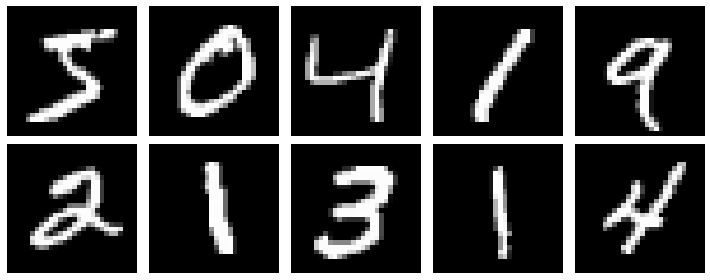

In [3]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets.mnist import load_data
import os

(X_train, y_train), (X_test, y_test) = load_data()
y_train, y_test = y_train.ravel(), y_test.ravel()
# The numpy.ravel() functions returns contiguous flattened array
# (1D array with all the input-array elements and with the same type as it). 

def plot_samples(data):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i], cmap = "gray")
        ax.axis("off")
    fig.tight_layout()

plot_samples(X_train)


In [18]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
X_train.min(), X_train.max()

(0.0, 0.003921569)

---
## Train|val|test split

In [5]:
from sklearn.model_selection import train_test_split

X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=1 / 6, random_state=42
)

X_train_val.shape

(50000, 28, 28)

In [6]:
# ImageDataGenerator requires rank 4 
X_train_val = X_train_val[:,:,:,None]
X_val = X_val[:,:,:,None]
X_train = X_train[:,:,:,None]
X_test = X_test[:,:,:,None]

X_train_val.shape

(50000, 28, 28, 1)

---
## Data augmentation
- ImageDataGenerator to augment images

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

plt.style.use("seaborn-white")

train_image_generator = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    height_shift_range=0.2,
    width_shift_range=0.2,
)

# don't augment test data and validation data as we want to test on original data
# we just instantiate an ImageDataGenerator without augmentation
test_image_generator = ImageDataGenerator()

# batch size 32 for mini-batch gradient descent 
train_val_generator = train_image_generator.flow(
    X_train_val, y_train_val, batch_size=32
)
# mini-batch gradient descent to get uncorrelated 
# batch size 32 for mini-batch gradient descent 

train_generator = train_image_generator.flow(
    X_train, y_train, batch_size=32
)

val_generator = test_image_generator.flow(X_val, y_val, batch_size=32)

# NumpyArrayIterator
train_val_generator, val_generator

(<keras.preprocessing.image.NumpyArrayIterator at 0x7f319cf81710>,
 <keras.preprocessing.image.NumpyArrayIterator at 0x7f31a0017250>)

In [8]:
print(len(train_val_generator.next()))
print(train_val_generator.next()[0].shape)
train_val_generator.next()

2
(32, 28, 28, 1)


(array([[[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         ...,
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]],
 
 
        [[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
      

2
(32, 28, 28, 1)


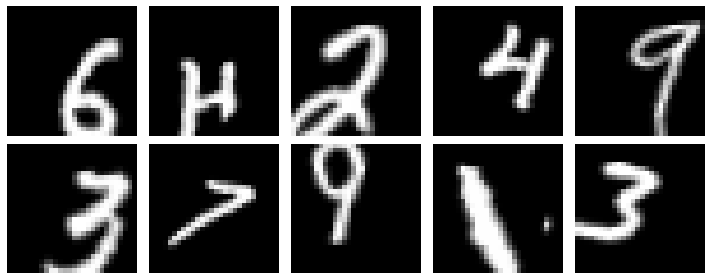

In [9]:
# an iterator can be iterated with a loop as the loop is calling the next() method
print(len(train_val_generator.next())) # tuple of (X_train_val, y_train_val)
print(train_val_generator.next()[0].shape) # 32 samples in a batch of images of
# shape (32,32,3)

plot_samples(train_val_generator.next()[0])


2
(32, 28, 28, 1)


array([1, 2, 6, 2, 7, 9, 9, 2, 8, 6, 8, 3, 4, 4, 4, 3, 4, 2, 2, 2, 4, 6,
       2, 7, 7, 5, 3, 1, 2, 1, 4, 0], dtype=uint8)

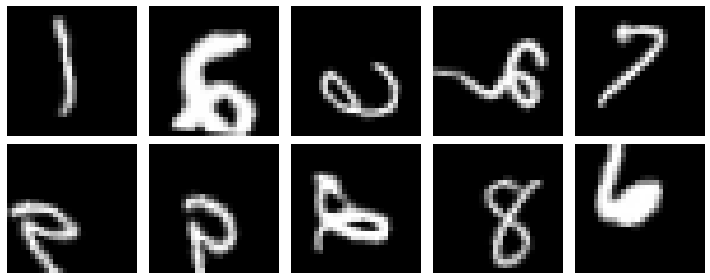

In [10]:
# an iterator can be iterated with a loop as the loop is calling the next() method
print(len(train_val_generator.next())) # tuple of (X_train_val, y_train_val)

sample_batch = train_val_generator.next()

print(sample_batch[0].shape) # 32 samples in a batch of images of
# shape (32,32,3)

plot_samples(sample_batch[0])
sample_batch[1]

---
## CNN model 

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def CNN_model(learning_rate=0.001, drop_rate=0.5, kernels=[32, 32]):
    adam = Adam(learning_rate=learning_rate)

    model = Sequential(name="CNN_model")

    for number_kernel in kernels:
        conv_layer = Conv2D(
            number_kernel,
            kernel_size=(3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=X_train.shape[1:],
        )

        model.add(conv_layer)
        # defaults to pool_size if None
        model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(10, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["acc"]
    )

    return model

model = CNN_model(drop_rate=.5)

model.summary()


Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dropout (Dropout)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               20

2022-04-28 08:14:29.866795: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Train on augmented data

 - steps_per_epoch is the number of times we generate our data from the generator
 - since we have batches on 32 samples for each time we generate, we could count how many samples before we cover original data size
 - 50000/32 = 

In [12]:
steps_per_epochs = int(len(X_train_val)/32)
validation_steps = int(len(X_val)/32)

steps_per_epoch, validation_steps


In [13]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(
    monitor="val_acc", mode="max", patience=5, restore_best_weights=True
)

model.fit(
    train_val_generator,
    steps_per_epoch=1500,
    epochs=100,
    callbacks=[early_stopper],
    validation_data=val_generator,
    validation_steps=312,
)


Epoch 1/100


2022-04-28 08:14:30.102895: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1500/1500 [==============================] - 27s 17ms/step - loss: 1.0303 - acc: 0.6480 - val_loss: 0.2915 - val_acc: 0.9138
Epoch 2/100
1500/1500 [==============================] - 27s 18ms/step - loss: 0.5316 - acc: 0.8270 - val_loss: 0.1495 - val_acc: 0.9553
Epoch 3/100
1500/1500 [==============================] - 27s 18ms/step - loss: 0.4152 - acc: 0.8647 - val_loss: 0.1161 - val_acc: 0.9646
Epoch 4/100
1500/1500 [==============================] - 27s 18ms/step - loss: 0.3571 - acc: 0.8858 - val_loss: 0.1137 - val_acc: 0.9667
Epoch 5/100
1500/1500 [==============================] - 27s 18ms/step - loss: 0.3227 - acc: 0.8976 - val_loss: 0.0903 - val_acc: 0.9713
Epoch 6/100
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2990 - acc: 0.9038 - val_loss: 0.0900 - val_acc: 0.9706
Epoch 7/100
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2817 - acc: 0.9092 - val_loss: 0.0933 - val_acc: 0.9706
Epoch 8/100
1500/1500 [==============================

In [14]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

,loss,acc,val_loss,val_acc
0,1.030278,0.647966,0.291456,0.913762
1,0.531625,0.827005,0.149550,0.955329
2,0.415201,0.864705,0.116057,0.964643
3,0.357086,0.885837,0.113707,0.966747
4,0.322688,0.897633,0.090257,0.971254


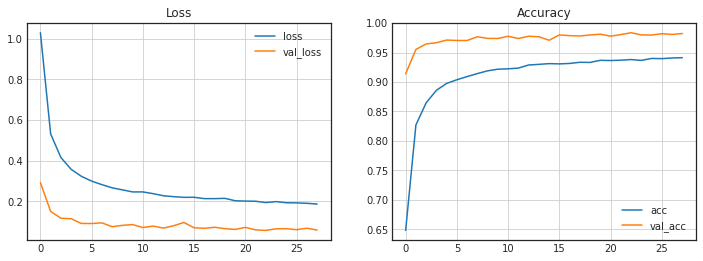

In [15]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], title = "Loss", grid = True)
    metrics[["acc", "val_acc"]].plot(ax = ax[1], title = "Accuracy", grid = True)

plot_metrics(metrics)
# val accuracy is higher than train accuracy, probably due to train data being
# augmented, which gives a lot of varieties in data and is harder to overfit

---
## Train on all training data

In [20]:
model = CNN_model()
model.fit(
    train_generator,
    steps_per_epoch=1500,
    epochs=15,
)


Epoch 1/15
1500/1500 [==============================] - 26s 17ms/step - loss: 0.9581 - acc: 0.6751
Epoch 2/15
1500/1500 [==============================] - 26s 17ms/step - loss: 0.4736 - acc: 0.8461
Epoch 3/15
1500/1500 [==============================] - 26s 17ms/step - loss: 0.3652 - acc: 0.8849
Epoch 4/15
1500/1500 [==============================] - 25s 17ms/step - loss: 0.3222 - acc: 0.8977
Epoch 5/15
1500/1500 [==============================] - 26s 17ms/step - loss: 0.2903 - acc: 0.9083
Epoch 6/15
1500/1500 [==============================] - 25s 16ms/step - loss: 0.2732 - acc: 0.9136
Epoch 7/15
1500/1500 [==============================] - 25s 17ms/step - loss: 0.2586 - acc: 0.9190
Epoch 8/15
1500/1500 [==============================] - 26s 17ms/step - loss: 0.2436 - acc: 0.9229
Epoch 9/15
1500/1500 [==============================] - 26s 17ms/step - loss: 0.2406 - acc: 0.9223
Epoch 10/15
1500/1500 [==============================] - 25s 17ms/step - loss: 0.2353 - acc: 0.9272
Epoch 11/

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.11      1.00      0.20      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.11     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.11      0.02     10000



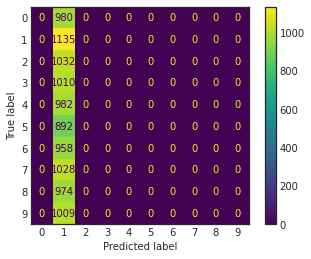

In [21]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

y_pred = model.predict(X_test)
#y_pred = np.argmax(y_pred)

y_pred = np.argmax(y_pred, axis = 1)


print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()